### Imports

In [1]:
#general 
import os
import numpy as np
import json
import random
from pathlib import Path 


#deep learning
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau

from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.callbacks.progress.tqdm_progress import TQDMProgressBar
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.utilities import rank_zero_only


import albumentations as A


In [2]:
os.getcwd()

'/Users/Theo/Documents/Depots-github/2023/inf573vegetalisation'

In [3]:
from count.data import get_data_paths
from CNN.utils_cnn import new_class, transform_to_only_trees_mask, display_samples, step_loading
from CNN.datamodule import OCS_DataModule
from CNN.model import SMP_Unet_meta
from CNN.task_module import SegmentationTask
from CNN.writer import PredictionWriter

/Users/Theo/Library/Caches/pypoetry/virtualenvs/inf573-s0HXXHew-py3.10/lib/python3.10/site-packages/pytorch_lightning/utilities/distributed.py:258: LightningDeprecationWarning: `pytorch_lightning.utilities.distributed.rank_zero_only` has been deprecated in v1.8.1 and will be removed in v2.0.0. You can import it from `pytorch_lightning.utilities` instead.
  rank_zero_deprecation(


# Data importation and display


### Data importation

In [4]:
path_toy_dataset_folder = './flair/dataflair/'

images = sorted(list(get_data_paths(Path(path_toy_dataset_folder), 'IMG*.tif')), key=lambda x: int(x.split('_')[-1][:-4]))
masks  = sorted(list(get_data_paths(Path(path_toy_dataset_folder), 'MSK*.tif')), key=lambda x: int(x.split('_')[-1][:-4]))

### Data display

In [5]:
#display_samples(images, masks, nb_samples=10)


# Model definition

In [6]:
config = {

    ############################
    # PATHS
    ############################
    'data': {
              'path_aerial_train': "./flairbigdataset/flair_aerial_train/",  #e.g.,  ./flair_aerial_train/
              'path_aerial_test':  "./flairbigdataset/flair_2_aerial_test/",  #e.g., ./flair_1_aerial_test/

              'path_labels_train': "./flairbigdataset/flair_labels_train/",  #e.g., ./flair_labels_train/
              'path_labels_test':  "./flair/dataflair/flair_2_labels_test/", #e.g.,  ./flair_1_labels_test/
              'path_metadata_aerial': "./flair-1_metadata_aerial.json", #e.g., ./flair-1_metadata_aerial.json
            },

    ############################
    # NAMINGS
    ############################    
    'outputs': {
                  'out_folder': "./trees_cnn_model/", 
                  'out_model_name': "trees_model_bigdataset_second_try",
               },

    
    ############################
    # CLASSES
    ############################    
    'num_classes': 7,

    ############################
    # TASKING
    ############################
    'use_weights': True,
    'class_weights': [1.0,1.0,1.0,1.0,1.0,1.0,2.0],
    'use_metadata': False,
    'use_augmentation': True,


    ############################
    # TRAINING 
    ############################
    'batch_size': 5,
    'learning_rate': 0.02,
    'num_epochs': 5,

    ############################
    # COMPUTATIONAL
    ############################
    'accelerator': 'cpu',
    'strategy':  None,#e.g., 'ddp' if multiple GPUs otherwise leave emtpy if single GPU training
    'num_nodes': 1,
    'gpus_per_node': 1,
    'num_workers': 8,

    ############################
    # PRINTS TRAINING
    ############################
    'enable_progress_bar': True,
    'progress_rate': 10,


}

## Dataloaders

In [7]:
out_dir = Path(config['outputs']["out_folder"], config['outputs']["out_model_name"])
out_dir.mkdir(parents=True, exist_ok=True)
seed_everything(2022, workers=True)

dict_train, dict_val, dict_test = step_loading(config["data"],use_metadata=config["use_metadata"])  

if config['use_augmentation'] == True:
    transform_set = A.Compose([A.VerticalFlip(p=0.5),
                               A.HorizontalFlip(p=0.5),
                               A.RandomRotate90(p=0.5)])
else:
    transform_set = None

dm = OCS_DataModule(
    dict_train = dict_train,
    dict_val = dict_val,
    dict_test = dict_test,
    batch_size = config["batch_size"],
    num_workers = config["num_workers"],
    drop_last = True,
    num_classes = config["num_classes"],
    num_channels = 5,
    use_metadata = config["use_metadata"],
    use_augmentations = transform_set)

Global seed set to 2022


+-----------------------------+    LOADING DATA    +-----------------------------+


## Model and learning setting

In [8]:
model = SMP_Unet_meta(n_channels=5, n_classes=config['num_classes'], use_metadata=config['use_metadata'])

In [9]:
with torch.no_grad():
        class_weights = torch.FloatTensor(config['class_weights'])
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [10]:
optimizer = torch.optim.SGD(model.parameters(), lr=config['learning_rate'])

In [11]:
scheduler = ReduceLROnPlateau(
    optimizer=optimizer,
    mode="min",
    factor=0.5,
    patience=10,
    cooldown=4,
    min_lr=1e-7,
)

In [12]:
seg_module = SegmentationTask(
    model=model,
    num_classes=dm.num_classes,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    use_metadata=config['use_metadata']
)

In [13]:
ckpt_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath=os.path.join(out_dir,"checkpoints"),
    filename="ckpt-{epoch:02d}-{val_loss:.2f}"+'_'+config['outputs']['out_model_name'],
    save_top_k=1,
    mode="min",
    save_weights_only=True, # can be changed accordingly
)

early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.00,
    patience=30, # if no improvement after 30 epoch, stop learning. 
    mode="min",
)

prog_rate = TQDMProgressBar(refresh_rate=config['progress_rate'])

callbacks = [
    ckpt_callback, 
    early_stop_callback,
    prog_rate,
]

In [14]:
logger = TensorBoardLogger(
    save_dir=out_dir,
    name=Path("tensorboard_logs"+'_'+config['outputs']['out_model_name']).as_posix()
)

loggers = [
    logger
]

# Model Training

In [15]:
#### instanciation of  Trainer
trainer = Trainer(
    accelerator = config["accelerator"],
    devices = config["gpus_per_node"],
    strategy = config["strategy"],
    num_nodes = config["num_nodes"],
    max_epochs = config["num_epochs"],
    num_sanity_val_steps = 0,
    callbacks = callbacks,
    logger = loggers,
    enable_progress_bar = config["enable_progress_bar"],
)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/Theo/Library/Caches/pypoetry/virtualenvs/inf573-s0HXXHew-py3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


In [16]:
trainer.fit(seg_module, datamodule=dm)

Missing logger folder: trees_cnn_model/trees_model_bigdataset_second_try/tensorboard_logs_trees_model_bigdataset_second_try

  | Name          | Type                   | Params
---------------------------------------------------------
0 | model         | SMP_Unet_meta          | 24.4 M
1 | criterion     | CrossEntropyLoss       | 0     
2 | train_metrics | MulticlassJaccardIndex | 0     
3 | val_metrics   | MulticlassJaccardIndex | 0     
4 | train_loss    | MeanMetric             | 0     
5 | val_loss      | MeanMetric             | 0     
---------------------------------------------------------
24.4 M    Trainable params
0         Non-trainable params
24.4 M    Total params
97.774    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [17]:
trainer.validate(seg_module, datamodule=dm)

Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            1.1624985933303833
        val_miou            0.27188655734062195
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 1.1624985933303833, 'val_miou': 0.27188655734062195}]

# Prediction

In [18]:
writer_callback = PredictionWriter(        
    output_dir = os.path.join(out_dir, "predictions"+"_"+config['outputs']["out_model_name"]),
    write_interval="batch",
)

#### instanciation of prediction Trainer
trainer = Trainer(
    accelerator = config["accelerator"],
    devices = config["gpus_per_node"],
    strategy = config["strategy"],
    num_nodes = config["num_nodes"],
    callbacks = [writer_callback],
    enable_progress_bar = config["enable_progress_bar"],
)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [19]:
from pytorch_lightning.utilities.distributed import rank_zero_only
trainer.predict(seg_module, datamodule=dm, return_predictions=False)

@rank_zero_only
def print_finish():
    print('--  [FINISHED.]  --', f'output dir : {out_dir}', sep='\n')
print_finish()

Predicting: 0it [00:00, ?it/s]

--  [FINISHED.]  --
output dir : trees_cnn_model/trees_model_bigdataset_second_try


In [20]:
from CNN.utils_cnn import get_data_paths, display_predictions

images_test = sorted(list(get_data_paths(Path(config['data']['path_aerial_test']), 'IMG*.tif')), key=lambda x: int(x.split('_')[-1][:-4]))
predictions = sorted(list(get_data_paths(Path(os.path.join(out_dir, "predictions"+"_"+config['outputs']["out_model_name"])), 'PRED*.tif')), key=lambda x: int(x.split('_')[-1][:-4]))

/Users/Theo/Library/Caches/pypoetry/virtualenvs/inf573-s0HXXHew-py3.10/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


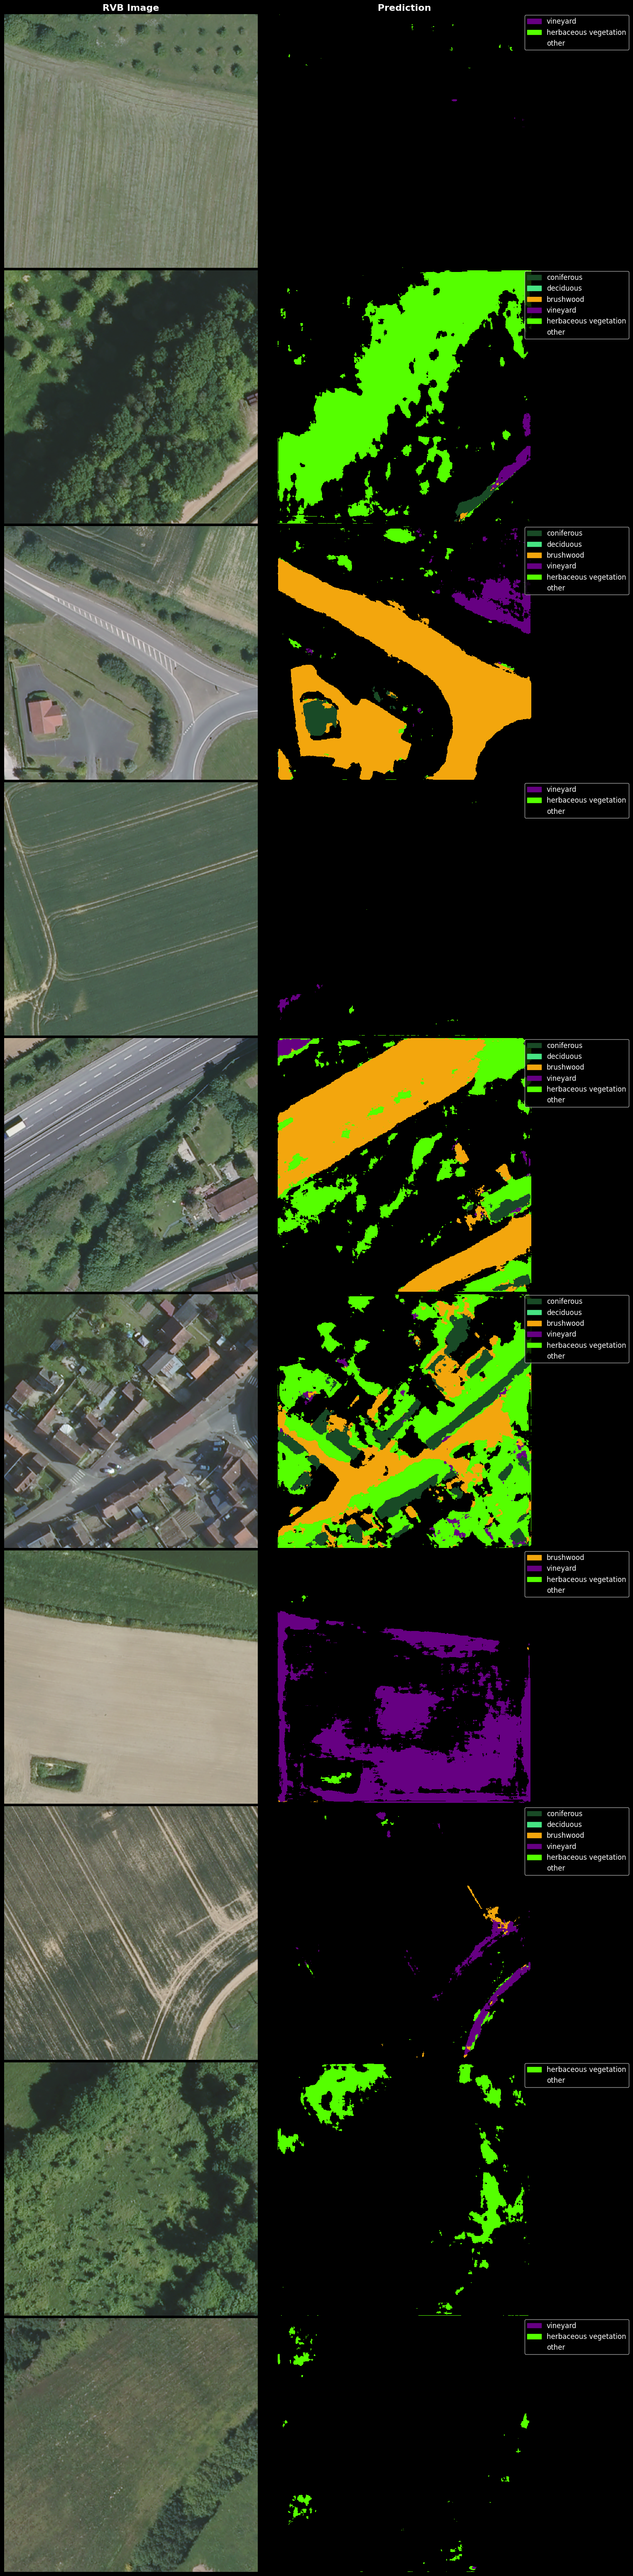

In [21]:
display_predictions(images_test, predictions, nb_samples=10)

In [22]:
os.listdir(Path(config['data']['path_aerial_test']))

['D061_2020',
 'D036_2020',
 'D026_2020',
 'D084_2021',
 'D071_2020',
 'D069_2020',
 'D064_2021',
 'D068_2021',
 'D022_2021',
 'D015_2020']